In [1]:
# Importing function:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
from collections import defaultdict

# NLP library
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk  
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
import string
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score


# nltk.download('vader_lexicon')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')


In [2]:
# reading input data
reviews_df = pd.read_csv("Hotel_Reviews.csv")
reviews_df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [3]:
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label based on reviews from customers
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


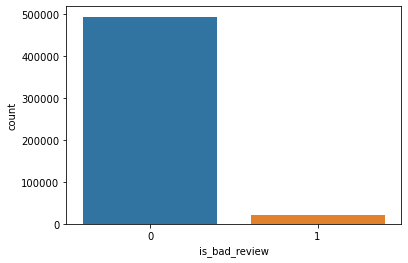

In [4]:
sns.countplot(data = reviews_df, x= 'is_bad_review')

In [5]:
# Downsample data, here we are taking 0.1% of orignal dataset
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)
reviews_df.shape

(51574, 2)

In [6]:
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.956761
1    0.043239
Name: is_bad_review, dtype: float64

In [7]:
# Removing 'No Negative' or 'No postive' to null values. Because we dont know what actual review is
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))
reviews_df.head()

,review,is_bad_review
488440,Would have appreciated a shop in the hotel th...,0
274649,No tissue paper box was present at the room,0
374688,Pillows Nice welcoming and service,0
404352,Everything including the nice upgrade The Hot...,0
451596,Lovely hotel v welcoming staff,0


In [8]:
# Cleaning review data by eliminating stopwords, punctuation.
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


In [9]:
# clean text data using above functions
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))
reviews_df.head()

,review,is_bad_review,review_clean
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...
274649,No tissue paper box was present at the room,0,tissue paper box present room
374688,Pillows Nice welcoming and service,0,pillow nice welcome service
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff


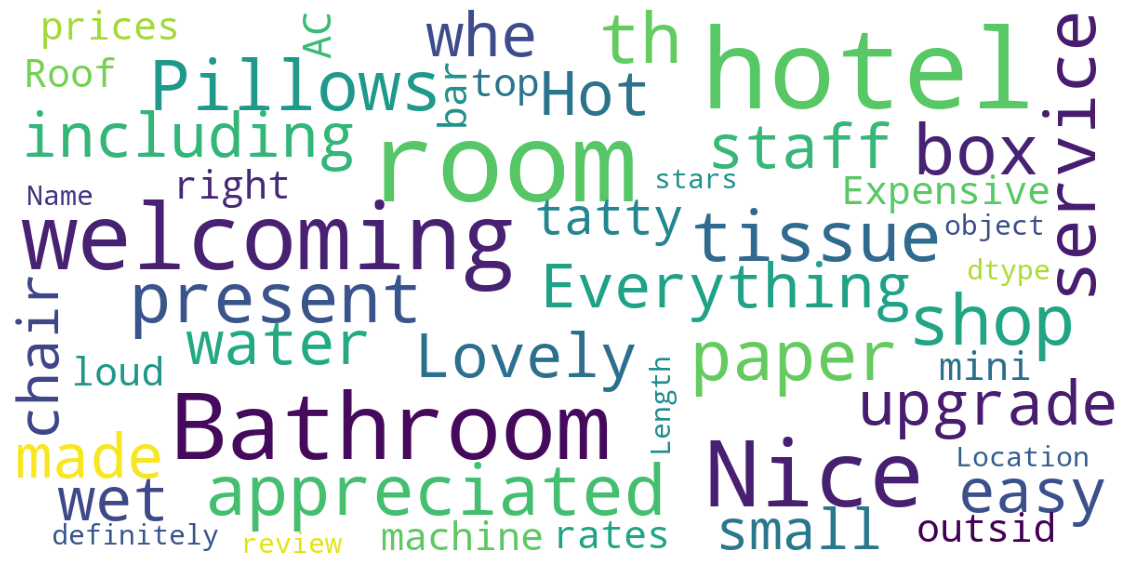

In [10]:
# wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [11]:
# Visualize Word Frequency plot 
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords.words('english')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(color=color))
    return trace

In [15]:
## Bar chart from +ve review ##
def frequent_word_plot(reviews_df, review, target ,ngram =1):
    """
    reviews_df = Dataset
    review = Text data or reviews column name
    Target = Label column name
    """
    train1_df = reviews_df[reviews_df[review]==1]
    train0_df = reviews_df[reviews_df[review]==0]
    freq_dict = defaultdict(int)
    for sent in train0_df[target]:
        for word in generate_ngrams(sent,ngram):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

    ## Get the bar chart from -ve review ##
    freq_dict = defaultdict(int)
    for sent in train1_df[target]:
        for word in generate_ngrams(sent,ngram):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

    # Creating two subplots
    fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of positive review", 
                                              "Frequent words of negative review"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    if ngram ==2:
        title="Bigram Count Plots"
    elif ngram==3:
        title="Trigram Count Plots"
    else:
        title="Word Count Plots"
    fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title=title)
    py.iplot(fig, filename='word-plots')


In [18]:
frequent_word_plot(reviews_df, 'is_bad_review', 'review' ,ngram =1)

In [16]:
frequent_word_plot(reviews_df, 'is_bad_review', 'review' ,ngram =2)

In [17]:
frequent_word_plot(reviews_df, 'is_bad_review', 'review' ,ngram =3)

In [19]:
# Distribution on train and test dataset
def EDA_distribution(train_df,test_df, review, target, plot= True):
    """
    train_df = Training dataset
    test_df = Testing dataset
    review = Text data or reviews
    Target = Label data
    """
    
    ## Number of words in the text ##
    train_df["num_words"] = train_df[review].apply(lambda x: len(str(x).split()))
    test_df["num_words"] = test_df[review].apply(lambda x: len(str(x).split()))

    ## Number of unique words in the text ##
    train_df["num_unique_words"] = train_df[review].apply(lambda x: len(set(str(x).split())))
    test_df["num_unique_words"] = test_df[review].apply(lambda x: len(set(str(x).split())))

    ## Number of characters in the text ##
    train_df["num_chars"] = train_df[review].apply(lambda x: len(str(x)))
    test_df["num_chars"] = test_df[review].apply(lambda x: len(str(x)))

    ## Number of stopwords in the text ##
    train_df["num_stopwords"] = train_df[review].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
    test_df["num_stopwords"] = test_df[review].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

    ## Number of punctuations in the text ##
    train_df["num_punctuations"] =train_df[review].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
    test_df["num_punctuations"] =test_df[review].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

    ## Number of title case words in the text ##
    train_df["num_words_upper"] = train_df[review].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    test_df["num_words_upper"] = test_df[review].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

    ## Number of title case words in the text ##
    train_df["num_words_title"] = train_df[review].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    test_df["num_words_title"] = test_df[review].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    ## Average length of the words in the text ##
    train_df["mean_word_len"] = train_df[review].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    test_df["mean_word_len"] = test_df[review].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


    ## Truncate some extreme values for better visuals ##
    train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
    train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
    train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

    f, axes = plt.subplots(3, 1, figsize=(10,20))
    sns.boxplot(x = target, y='num_words', data=train_df, ax=axes[0])
    axes[0].set_xlabel('Target', fontsize=12)
    axes[0].set_title("Number of words in each class", fontsize=15)

    sns.boxplot(x = target, y='num_chars', data=train_df, ax=axes[1])
    axes[1].set_xlabel('Target', fontsize=12)
    axes[1].set_title("Number of characters in each class", fontsize=15)

    sns.boxplot(x = target, y='num_punctuations', data=train_df, ax=axes[2])
    axes[2].set_xlabel('Target', fontsize=12)
    #plt.ylabel('Number of punctuations in text', fontsize=12)
    axes[2].set_title("Number of punctuations in each class", fontsize=15)
    plt.show()
    return train_df, test_df

####  SentimentAnalyzer is a tool to implement and facilitate Sentiment Analysis tasks using NLTK features and classifiers.
polarity_scores: Return a float for sentiment strength based on the input text. Positive values are positive valence, negative value are negative valence

In [20]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)


In [21]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717


In [22]:
df = reviews_df.copy()

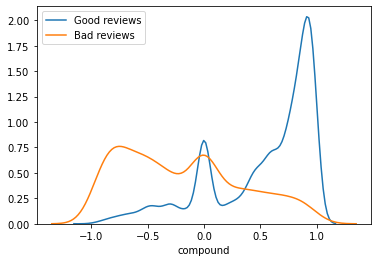

In [43]:
# plot sentiment distribution for positive and negative reviews
for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [23]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))
# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7


In [24]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.001850,-0.218036,0.027399,-0.022400,0.105609
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.120988,0.111744,0.058279,0.040049,-0.078150
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.014913,0.018297,-0.032178,-0.035656,0.000054
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.058788,0.136924,-0.051847,-0.065031,0.160514
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.065415,-0.006433,0.005089,-0.052522,0.025659


In [25]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.001850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.120988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.014913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.058788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.065415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.956761
1    0.043239
Name: is_bad_review, dtype: float64

In [27]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df[ "nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
128308,Super friendly staff,0.877


In [28]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743


In [64]:
reviews_df

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.001850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.120988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.014913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.058788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.065415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,0,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834,142,25,-0.208766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9732,Room very small chair tatty in the room,1,room small chair tatty room,0.000,1.000,0.000,0.0000,41,10,-0.123278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424201,Expensive rates and mini bar prices Roof top ...,0,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023,80,16,-0.111515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72380,There was a very loud AC machine right outsid...,0,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767,176,36,0.042399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
reviews_df.drop('is_bad_review',axis=1)

,review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
488440,Would have appreciated a shop in the hotel th...,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,113,-0.001850,-0.218036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274649,No tissue paper box was present at the room,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,10,0.120988,0.111744,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374688,Pillows Nice welcoming and service,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,7,-0.014913,0.018297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404352,Everything including the nice upgrade The Hot...,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,27,-0.058788,0.136924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451596,Lovely hotel v welcoming staff,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,7,-0.065415,-0.006433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274862,Bathroom water easy made the bathroom wet whe...,bathroom water easy make bathroom wet bath wal...,0.000,0.614,0.386,0.8834,142,25,-0.208766,0.120636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9732,Room very small chair tatty in the room,room small chair tatty room,0.000,1.000,0.000,0.0000,41,10,-0.123278,0.004024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424201,Expensive rates and mini bar prices Roof top ...,expensive rate mini bar price roof top pool vi...,0.000,0.886,0.114,0.2023,80,16,-0.111515,-0.144863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72380,There was a very loud AC machine right outsid...,loud ac machine right outside window affect sl...,0.047,0.845,0.108,0.4767,176,36,0.042399,-0.022001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# feature selection and then training model
label = "is_bad_review"

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(reviews_df.drop(label,axis=1), reviews_df[label], test_size = 0.20, random_state = 42)

ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]
X_train_new = X_train[features]
X_test_new = X_test[features]

In [78]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train_new, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.037740
2,pos,0.025271
0,neg,0.022751
6,doc2vec_vector_0,0.020077
9,doc2vec_vector_3,0.019237
8,doc2vec_vector_2,0.018724
10,doc2vec_vector_4,0.017788
7,doc2vec_vector_1,0.016968
4,nb_chars,0.016458
1,neu,0.015388


In [79]:
# import eli5
# eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

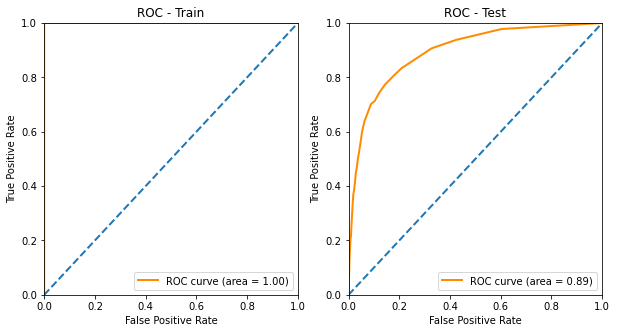

In [80]:
# ROC curve
def ROC_curve(df_train_x, df_train_y, df_test_x, df_test_y, model):
    y_pred_train = [x[1] for x in model.predict_proba(df_train_x)]
    y_pred_test = [x[1] for x in model.predict_proba(df_test_x)]
    fpr_train, tpr_train, _ = roc_curve(df_train_y, y_pred_train)
    fpr_test, tpr_test, _ = roc_curve(df_test_y, y_pred_test)
    
    roc_auc = auc(fpr_train, tpr_train)
    plt.figure(1, figsize = (10, 5))
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fpr_train, tpr_train, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Train')
    plt.legend(loc="lower right")
    
    roc_auc = auc(fpr_test, tpr_test)
    plt.subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - Test')
    plt.legend(loc="lower right")
    
ROC_curve(X_train_new, y_train, X_test_new, y_test, rf)

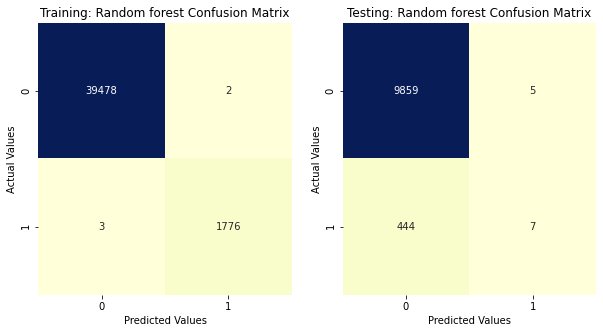

In [82]:
def create_conf_mat(col,y_train,heading):
    def create_mat(test_class_set, predictions):
        """Function returns confusion matrix comparing two arrays"""
        if (len(test_class_set.shape) != len(predictions.shape) == 1):
            return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
        elif (test_class_set.shape != predictions.shape):
            return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
        else:
            # Set Metrics
            test_crosstb_comp = pd.crosstab(index = test_class_set,
                                            columns = predictions)
            # Changed for Future deprecation of as_matrix
            test_crosstb = test_crosstb_comp.values
            return test_crosstb
    
    for i, val in enumerate(col):
        conf_mat = create_mat(y_train, val)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
        plt.xlabel('Predicted Values')
        plt.ylabel('Actual Values')
        plt.title(heading)

plt.figure(1, figsize = (10, 5))
plt.subplot(1, 2, 1)
pred_train_list = [rf.predict(X_train_new)]
create_conf_mat(pred_train_list, y_train, 'Training: Random forest Confusion Matrix')
   
plt.subplot(1, 2, 2)
pred_test_list = [rf.predict(X_test_new)]
create_conf_mat(pred_test_list, y_test, 'Testing: Random forest Confusion Matrix')


In [83]:
X_train

,review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,...,word_yet,word_yoghurt,word_yogurt,word_young,word_yr,word_yummy,word_zero,word_ziggo,word_zone,word_zuid
172455,However there was no complimentary wifi in th...,however complimentary wifi standard room optio...,0.023,0.844,0.134,0.8360,332,70,-0.003729,0.019017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81167,Bathroom has a slightly damp smell but was ot...,bathroom slightly damp smell otherwise clean f...,0.078,0.429,0.493,0.9862,239,46,-0.054278,-0.218826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451980,Nothing Everything,nothing everything,0.000,1.000,0.000,0.0000,19,3,-0.075745,0.051183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327854,No coffee in the room the shower smelled and ...,coffee room shower smell fix breakfast expensi...,0.048,0.526,0.425,0.9451,190,37,-0.068674,0.017768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472820,The room was a bit small for the price and th...,room bit small price bed come bad quality matt...,0.058,0.739,0.203,0.8130,314,61,-0.135786,0.020705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467025,Hotel is dated poor amenities rooms are dusty...,hotel date poor amenity room dusty close curta...,0.086,0.885,0.030,-0.6013,516,106,0.014571,0.018141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65675,Stuff was unfriendly not helpful whatsover Ne...,stuff unfriendly helpful whatsover need ask la...,0.166,0.676,0.158,0.3987,205,37,0.090106,-0.239624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401118,Excellent room with terrace fantastic rooftop...,excellent room terrace fantastic rooftop bar g...,0.000,0.385,0.615,0.9432,101,17,-0.057589,-0.059794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466346,Fantastic beautiful location elegant room out...,fantastic beautiful location elegant room outs...,0.000,0.255,0.745,0.9393,79,11,-0.137579,-0.079299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
score_train = pd.DataFrame()
score_train['review'] = X_train['review']
score_train['label'] = y_train
score_train['RF_score'] = rf.predict_proba(X_train_new)[:, 1]
score_train['Record_category'] = 'Train'

score_test = pd.DataFrame()
score_test['review'] = X_test['review']
score_test['label'] = y_test
score_test['RF_score'] = rf.predict_proba(X_test_new)[:, 1]
score_test['Record_category'] = 'Test'

score = pd.concat([score_train, score_test]).reset_index(drop=True)
score.head()

,review,label,RF_score,Record_category
0,However there was no complimentary wifi in th...,0,0.00,Train
1,Bathroom has a slightly damp smell but was ot...,0,0.01,Train
2,Nothing Everything,0,0.00,Train
3,No coffee in the room the shower smelled and ...,0,0.02,Train
4,The room was a bit small for the price and th...,0,0.01,Train
